# Bayesian - Gaussian random walk
### Voting Intention aggregation - 2028 Election

## Python set-up

In [1]:
"""Setup and imports."""

import sys
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import mgplot as mg
import numpy as np
import pandas as pd

# Add pymc tools to path
sys.path.insert(0, "pymc")

from bayes_tools import check_residuals, draw_samples, grw_model, prepare_data_for_analysis
from common import MIDDLE_DATE
from extraction import get_vector_var
from plot_house_effects import plot_house_effects_bar
from plot_posterior_timeseries import plot_posterior_timeseries
from plot_posteriors_bar import plot_posteriors_bar
from polling_data_etl import load_polling_data
from previous_election import get_election_result

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

SHOW = True
RFOOTER = "marktheballot.blogspot.com"
LFOOTER = "Australia. Polling data sourced from Wikipedia. "

In [2]:
# Set up plotting directory
mg.set_chart_dir("../charts/bayesian-aggregation/")
mg.clear_chart_dir()

## Load Polling Data

Load the most recent voting intention polling data using the ETL module.

In [3]:
# Load voting intention data
df_raw = load_polling_data("voting_intention")
print(f"\nLoaded {len(df_raw)} polls")
print(f"\nColumns: {list(df_raw.columns)}")

Using today's voting_intention data file: ../poll-data/voting_intention_next_2025-12-30.csv

Loaded 45 polls

Columns: ['Date', 'Brand', 'Interview mode', 'Sample size', 'Primary vote ALP', 'Primary vote L/NP', 'Primary vote GRN', 'Primary vote ONP', 'Primary vote IND', 'Primary vote OTH', '2PP vote ALP', '2PP vote L/NP', 'parsed_date', 'problematic']


In [4]:
# Display the raw data
df_raw.head(10)

Date         Brand    Interview mode  Sample size  \
parsed_date                                                                  
NaT                      Date          Firm    Interview mode          NaN   
2025-12-18   17 – 20 Dec 2025       Resolve  Telephone/Online       1010.0   
2025-12-11    8 – 14 Dec 2025    Roy Morgan            Online       1574.0   
2025-12-08    5 – 12 Dec 2025     Redbridge            Online       1012.0   
2025-12-05     3 – 8 Dec 2025     Essential            Online       1300.0   
2025-12-04     2 – 7 Dec 2025       Resolve  Telephone/Online       1800.0   
2025-11-16    7 – 26 Nov 2025     Redbridge            Online       4775.0   
2025-11-21   19 – 24 Nov 2025     Essential            Online       1020.0   
2025-11-18   17 – 20 Nov 2025      Newspoll            Online       1245.0   
2025-11-14   12 – 17 Nov 2025  YouGov (MRP)            Online       3530.0   

             Primary vote ALP  Primary vote L/NP  Primary vote GRN  \
parsed_date                                                          
NaT                       NaN                NaN               NaN   
2025-12-18          32.000000          28.000000         12.000000   
2025-12-11          30.500000          27.500000         13.000000   
2025-12-08          35.000000          26.000000         13.000000   
2025-12-05          35.789474          27.368421         10.526316   
2025-12-04          35.000000          26.000000         11.000000   
2025-11-16          35.000000          26.000000         10.000000   
2025-11-21          38.250000          28.687500         11.687500   
2025-11-18          36.000000          24.000000         13.000000   
2025-11-14          34.000000          26.000000         12.000000   

             Primary vote ONP  Primary vote IND  Primary vote OTH  \
parsed_date                                                         
NaT                       NaN               NaN               NaN   
2025-12-18          16.000000               8.0          4.000000   
2025-12-11          17.000000               NaN         12.000000   
2025-12-08          17.000000               NaN          9.000000   
2025-12-05          17.894737               NaN          8.421053   
2025-12-04          14.000000               8.0          6.000000   
2025-11-16          18.000000               NaN         11.000000   
2025-11-21          15.937500               NaN          7.437500   
2025-11-18          15.000000               NaN         12.000000   
2025-11-14          18.000000               5.0          5.000000   

             2PP vote ALP  2PP vote L/NP parsed_date  problematic  
parsed_date                                                        
NaT                   NaN            NaN         NaN         True  
2025-12-18           54.0           46.0  2025-12-18        False  
2025-12-11           54.5           45.5  2025-12-11        False  
2025-12-08           56.0           44.0  2025-12-08        False  
2025-12-05           52.1           47.9  2025-12-05        False  
2025-12-04           55.0           45.0  2025-12-04        False  
2025-11-16           54.0           46.0  2025-11-16        False  
2025-11-21           53.2           46.8  2025-11-21        False  
2025-11-18           58.0           42.0  2025-11-18        False  
2025-11-14           54.8           45.2  2025-11-14        False

## Data Preparation

Prepare the data for Bayesian analysis - ensure correct column names and create derived columns.

In [5]:
# Data preparation
df = df_raw.copy()

# Rename parsed_date to Mean Date for compatibility with bayes_tools
if "parsed_date" in df.columns and MIDDLE_DATE not in df.columns:
    df[MIDDLE_DATE] = pd.to_datetime(df["parsed_date"])

# Convert numeric columns
numeric_cols = ["2PP vote ALP", "2PP vote L/NP", "Primary vote ALP", "Primary vote L/NP",
                "Primary vote GRN", "Primary vote ONP", "Primary vote IND", "Primary vote OTH",
                "Sample size"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Create "Others Primary Vote" by summing remaining primary vote columns
main_primary_cols = ["Primary vote ALP", "Primary vote L/NP", "Primary vote GRN", "Primary vote ONP"]
remaining = [c for c in df.columns if c not in main_primary_cols and "Primary vote" in c]
df["Others Primary Vote"] = df[remaining].sum(axis=1, skipna=True)
# Set to NaN where all source columns are NaN
all_nan_rows = df[remaining].isna().all(axis=1)
df.loc[all_nan_rows, "Others Primary Vote"] = np.nan
print(f"Created 'Others Primary Vote' from columns: {remaining}")

print(f"Prepared {len(df)} polls")
df.head()

Created 'Others Primary Vote' from columns: ['Primary vote IND', 'Primary vote OTH']
Prepared 45 polls


Date       Brand    Interview mode  Sample size  \
parsed_date                                                                
NaT                      Date        Firm    Interview mode          NaN   
2025-12-18   17 – 20 Dec 2025     Resolve  Telephone/Online       1010.0   
2025-12-11    8 – 14 Dec 2025  Roy Morgan            Online       1574.0   
2025-12-08    5 – 12 Dec 2025   Redbridge            Online       1012.0   
2025-12-05     3 – 8 Dec 2025   Essential            Online       1300.0   

             Primary vote ALP  Primary vote L/NP  Primary vote GRN  \
parsed_date                                                          
NaT                       NaN                NaN               NaN   
2025-12-18          32.000000          28.000000         12.000000   
2025-12-11          30.500000          27.500000         13.000000   
2025-12-08          35.000000          26.000000         13.000000   
2025-12-05          35.789474          27.368421         10.526316   

             Primary vote ONP  Primary vote IND  Primary vote OTH  \
parsed_date                                                         
NaT                       NaN               NaN               NaN   
2025-12-18          16.000000               8.0          4.000000   
2025-12-11          17.000000               NaN         12.000000   
2025-12-08          17.000000               NaN          9.000000   
2025-12-05          17.894737               NaN          8.421053   

             2PP vote ALP  2PP vote L/NP parsed_date  problematic  Mean Date  \
parsed_date                                                                    
NaT                   NaN            NaN         NaN         True        NaT   
2025-12-18           54.0           46.0  2025-12-18        False 2025-12-18   
2025-12-11           54.5           45.5  2025-12-11        False 2025-12-11   
2025-12-08           56.0           44.0  2025-12-08        False 2025-12-08   
2025-12-05           52.1           47.9  2025-12-05        False 2025-12-05   

             Others Primary Vote  
parsed_date                       
NaT                          NaN  
2025-12-18             12.000000  
2025-12-11             12.000000  
2025-12-08              9.000000  
2025-12-05              8.421053

In [6]:
# Check pollsters (Brand) in the data
print("Pollsters in data:")
print(df["Brand"].value_counts())

Pollsters in data:
Brand
Roy Morgan          9
Resolve             7
Redbridge           6
Newspoll            6
Essential           4
YouGov (MRP)        3
Firm                2
Spectre Strategy    2
YouGov              2
DemosAU (MRP)       1
Freshwater          1
Wolf & Smith        1
DemosAU             1
Name: count, dtype: int64


In [7]:
# Date range
print(f"Date range: {df[MIDDLE_DATE].min()} to {df[MIDDLE_DATE].max()}")
print(f"Number of days: {(df[MIDDLE_DATE].max() - df[MIDDLE_DATE].min()).days}")

Date range: 2025-05-18 00:00:00 to 2025-12-18 00:00:00
Number of days: 214


## Data Exploration

In [8]:
# Summary statistics
available_cols = [c for c in numeric_cols if c in df.columns]
df[available_cols].describe()

2PP vote ALP  2PP vote L/NP  Primary vote ALP  Primary vote L/NP  \
count     41.000000      41.000000         41.000000          41.000000   
mean      55.739024      44.260976         35.343945          28.077255   
std        1.760948       1.760948          1.918630           2.173837   
min       52.100000      41.000000         30.500000          24.000000   
25%       54.500000      43.000000         34.000000          27.000000   
50%       56.000000      44.000000         35.789474          28.000000   
75%       57.000000      45.500000         36.500000          30.000000   
max       59.000000      47.900000         40.000000          31.000000   

       Primary vote GRN  Primary vote ONP  Primary vote IND  Primary vote OTH  \
count         40.000000         40.000000         10.000000         39.000000   
mean          11.992098         12.598319          8.490239         10.823377   
std            1.329038          3.974513          2.873176          3.200592   
min            9.000000          6.000000          5.000000          4.000000   
25%           11.000000          9.000000          7.283228          8.210526   
50%           12.000000         12.060606          8.000000         12.000000   
75%           12.575000         15.968085          8.683168         13.250000   
max           17.000000         21.000000         16.000000         15.000000   

       Sample size  
count    43.000000  
mean   2672.581395  
std    1776.784686  
min    1001.000000  
25%    1264.000000  
50%    1800.000000  
75%    4676.500000  
max    6928.000000

## Prepare Data for Bayesian Analysis

Use `prepare_data_for_analysis` from bayes_tools to create the inputs dictionary for the model.

In [9]:
# Configuration
# House effect constraint: "zero_median" (default) or "zero_sum"
# - zero_median: median of ALL house effects = 0
# - zero_sum: mean of included pollsters = 0 (excludes those with < MIN_POLLS)
MIN_POLLS = 5  # Only used with zero_sum constraint

# Columns to analyse
VOTE_COLUMNS = [
    "2PP vote ALP",
    "2PP vote L/NP",
    "Primary vote ALP",
    "Primary vote L/NP",
    "Primary vote GRN",
    "Primary vote ONP",
    "Others Primary Vote",
]

# Palettes for plots (matplotlib colormap names)
PALETTES = {
    "ALP": "Reds",
    "L/NP": "Blues",
    "GRN": "Greens",
    "ONP": "YlOrBr",
    "Others": "BuPu",
}


def get_palette(column: str) -> str:
    """Get the palette for a column based on party."""
    for party, palette in PALETTES.items():
        if party in column:
            return palette
    return "Blues"

## Run GRW Model for All Vote Columns

In [10]:
def run_grw_for_column(
    df: pd.DataFrame,
    column: str,
    constraint: str = "zero_median",  # "zero_median" or "zero_sum"
    min_polls: int = 5,  # Only used with zero_sum constraint
    draws: int = 5000,
    tune: int = 1000,
    cores: int = 4,
    target_accept: float = 0.80,
    max_tree_depth: int = 12,  # Increase from default 10 for zero_median
    innovation: float = 0.1,
    likelihood: str = "StudentT",  # "Normal" or "StudentT" for robust estimation
) -> dict:
    """Run GRW model for a single column and return results."""
    
    print(f"\n{'='*60}")
    print(f"Processing: {column}")
    print(f"{'='*60}")
    
    # Filter to rows with valid data for this column
    df_analysis = df[df[column].notna()].copy()
    
    # Get poll counts by pollster
    poll_counts = df_analysis["Brand"].value_counts()
    
    print(f"Polls: {len(df_analysis)}")
    print(f"Pollsters: {list(poll_counts.index)}")
    print(f"Constraint: {constraint}")
    
    # Prepare data - exclusions only needed for zero_sum constraint
    if constraint == "zero_sum":
        he_sum_exclusions = poll_counts[poll_counts < min_polls].index.tolist()
        print(f"Excluded from sum-to-zero (n<{min_polls}): {he_sum_exclusions}")
        inputs = prepare_data_for_analysis(
            df_analysis,
            column=column,
            he_sum_exclusions=he_sum_exclusions,
        )
    else:
        inputs = prepare_data_for_analysis(
            df_analysis,
            column=column,
        )
    
    # Build and run model
    model = grw_model(inputs, innovation=innovation, likelihood=likelihood, constraint=constraint)
    idata, glitches = draw_samples(
        model, 
        draws=draws, 
        tune=tune, 
        cores=cores,
        target_accept=target_accept,
        nuts_sampler="numpyro",
        nuts_sampler_kwargs={"nuts_kwargs": {"max_tree_depth": max_tree_depth}},
    )
    
    if glitches:
        print(f"WARNING: {glitches}")
    
    print(f"Completed: {column}")
    
    return {
        "inputs": inputs,
        "model": model,
        "idata": idata,
        "glitches": glitches,
        "constraint": constraint,
        "poll_counts": poll_counts.to_dict(),
    }


Processing: 2PP vote ALP
Polls: 41
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'Spectre Strategy', 'YouGov', 'YouGov (MRP)', 'DemosAU (MRP)', 'Freshwater', 'Wolf & Smith', 'DemosAU']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 2885
Maximum MCSE/sd ratio: 0.019
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 0.51% (comparing to observed max)
Minimum BFMI: 0.94
Completed: 2PP vote ALP


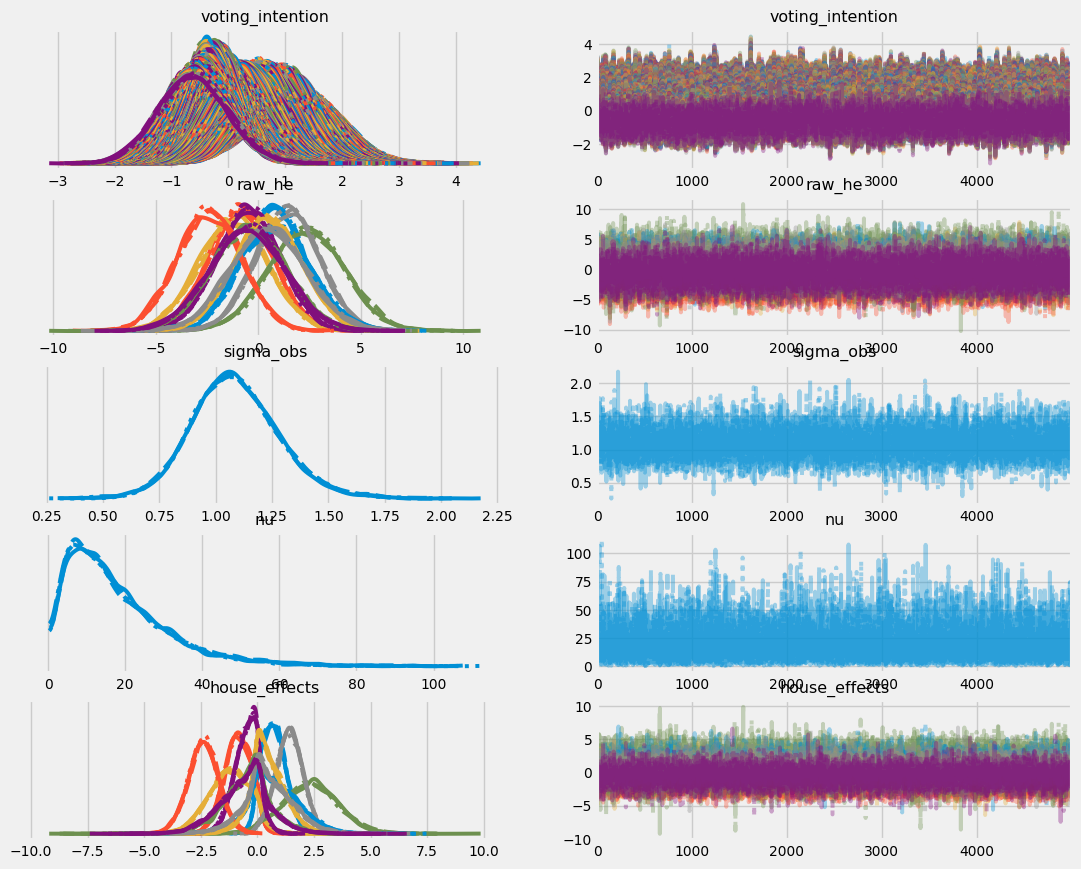

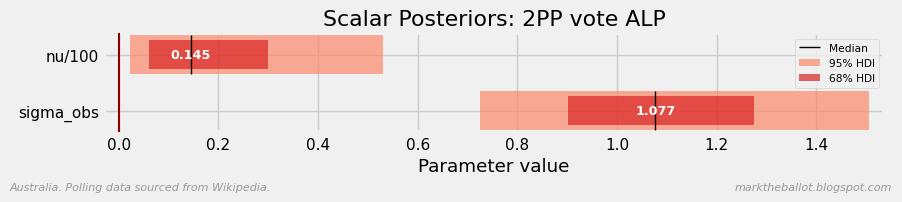

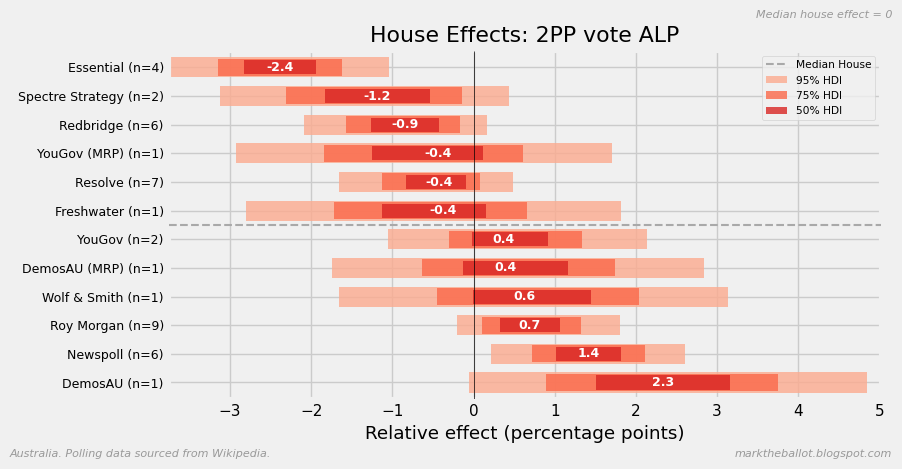

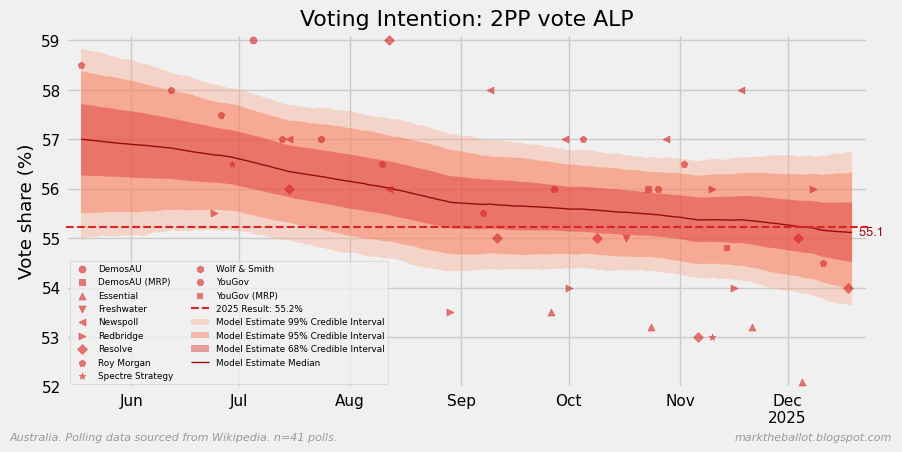


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.09
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.113 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.61 (t-test p=0.208)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.273 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.68 (t-test p=0.122)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.741 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +0.88 (t-test p=0.346)

Resolve (n=7) ⚠️ SUSPECT
  Outside ±3σ: 1/7 (14.3%)
  Heteroskedasticity p-value: 0.460 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -1.73 (t-test p=0.275)

⚠️  1 pollster(s) flagged for potential methodology issues:
   - Resolve


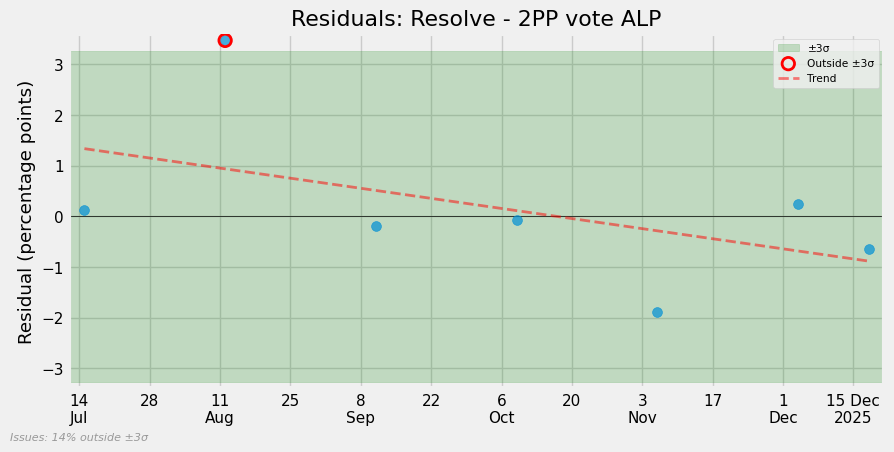


Processing: 2PP vote L/NP
Polls: 41
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'Spectre Strategy', 'YouGov', 'YouGov (MRP)', 'DemosAU (MRP)', 'Freshwater', 'Wolf & Smith', 'DemosAU']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 2806
Maximum MCSE/sd ratio: 0.020
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 0.11% (comparing to observed max)
Minimum BFMI: 1.00
Completed: 2PP vote L/NP


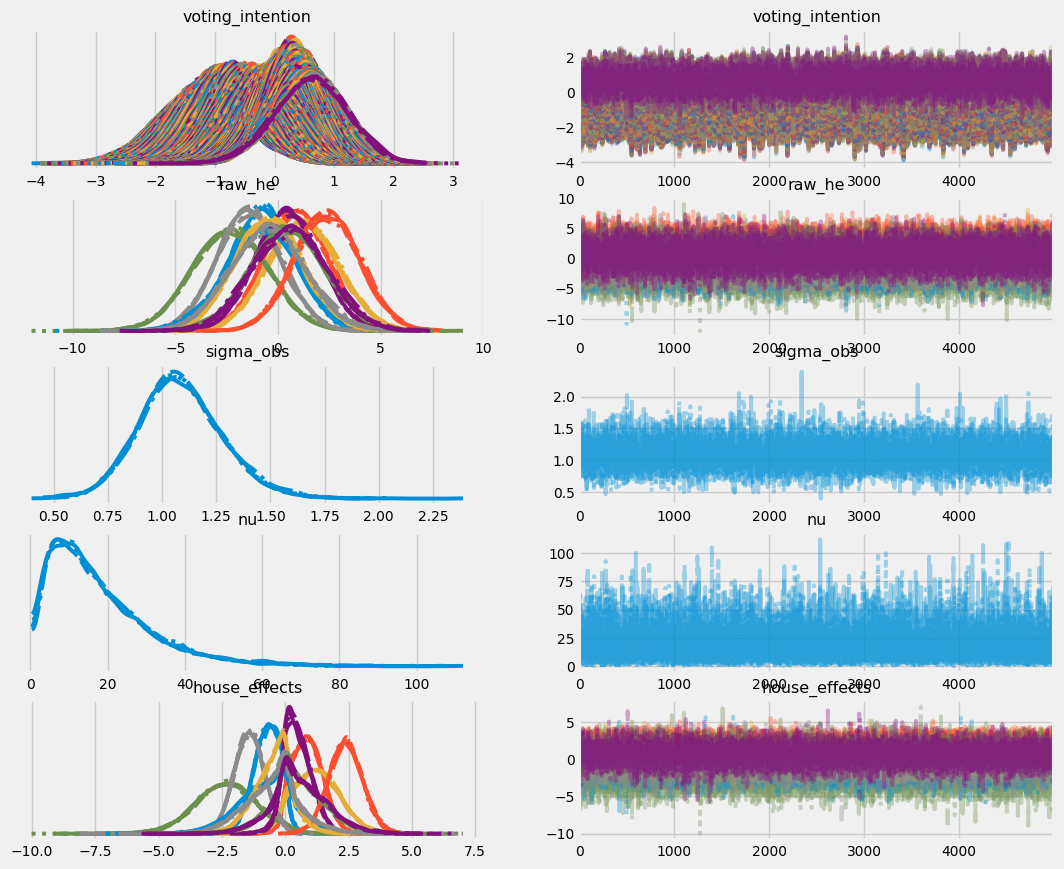

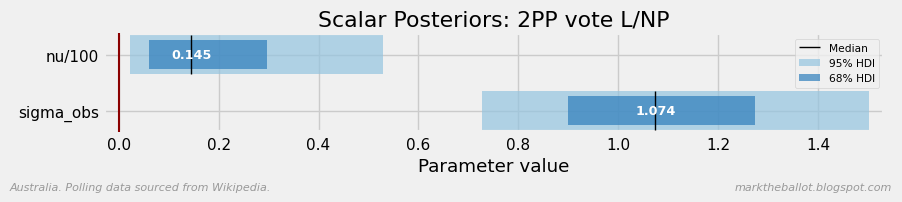

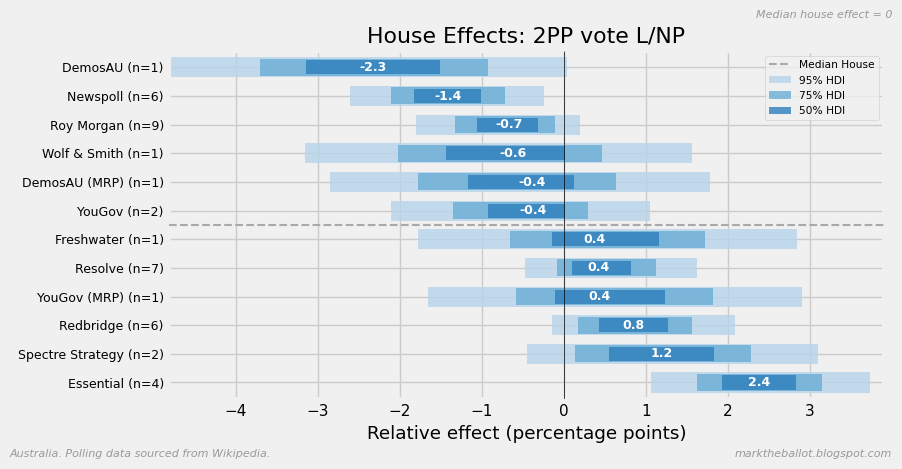

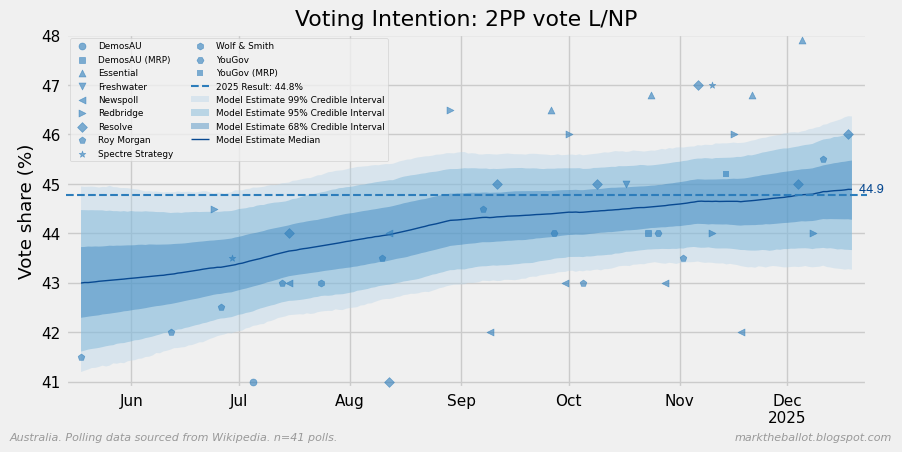


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.09
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.106 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +0.60 (t-test p=0.217)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.277 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -1.68 (t-test p=0.120)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.739 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.88 (t-test p=0.343)

Resolve (n=7) ⚠️ SUSPECT
  Outside ±3σ: 1/7 (14.3%)
  Heteroskedasticity p-value: 0.460 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.72 (t-test p=0.276)

⚠️  1 pollster(s) flagged for potential methodology issues:
   - Resolve


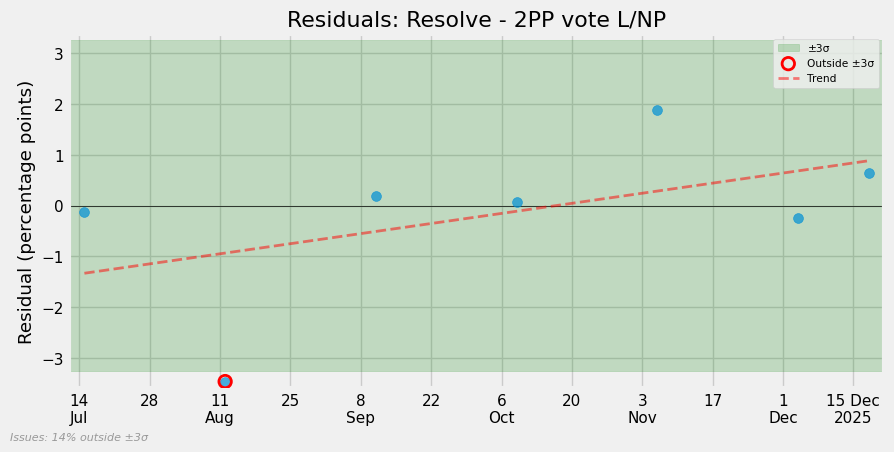


Processing: Primary vote ALP
Polls: 41
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'YouGov (MRP)', 'Spectre Strategy', 'DemosAU (MRP)', 'YouGov', 'Freshwater', 'Wolf & Smith', 'DemosAU']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 2984
Maximum MCSE/sd ratio: 0.019
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 0.07% (comparing to observed max)
Minimum BFMI: 0.99
Completed: Primary vote ALP


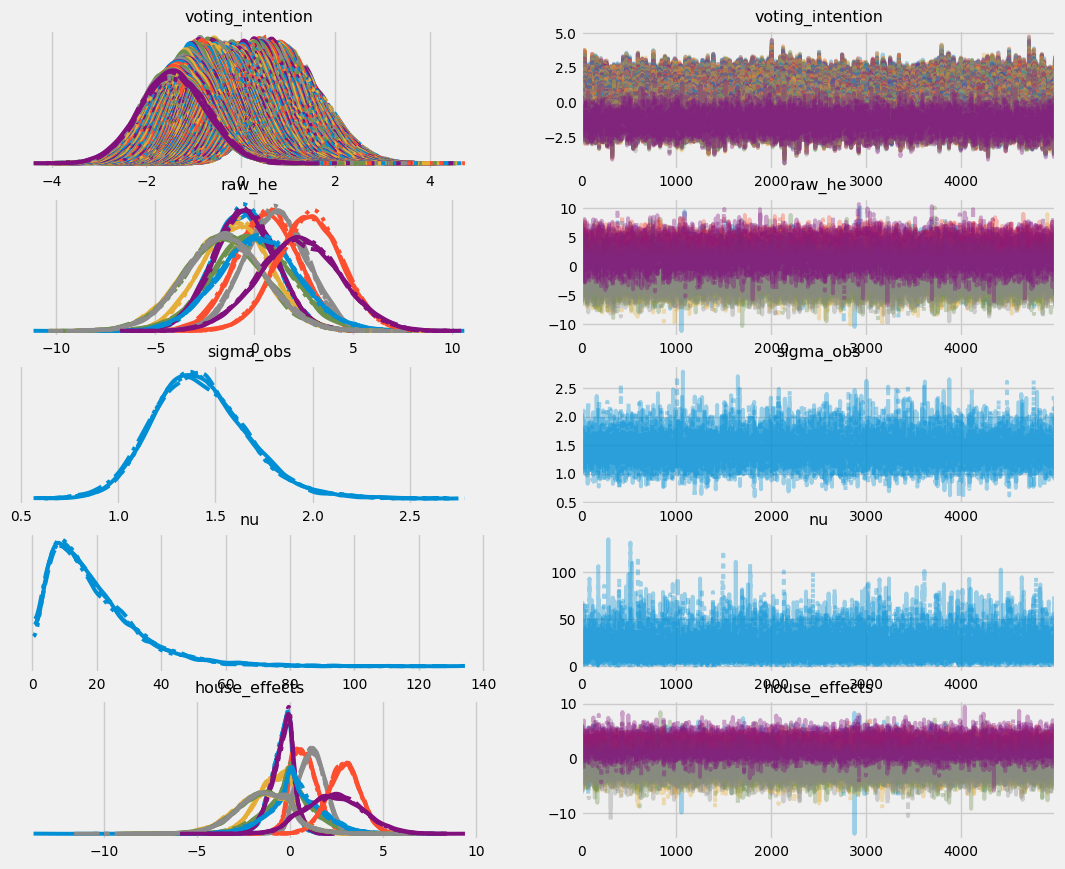

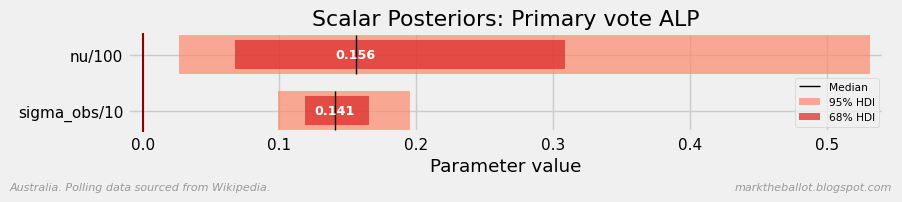

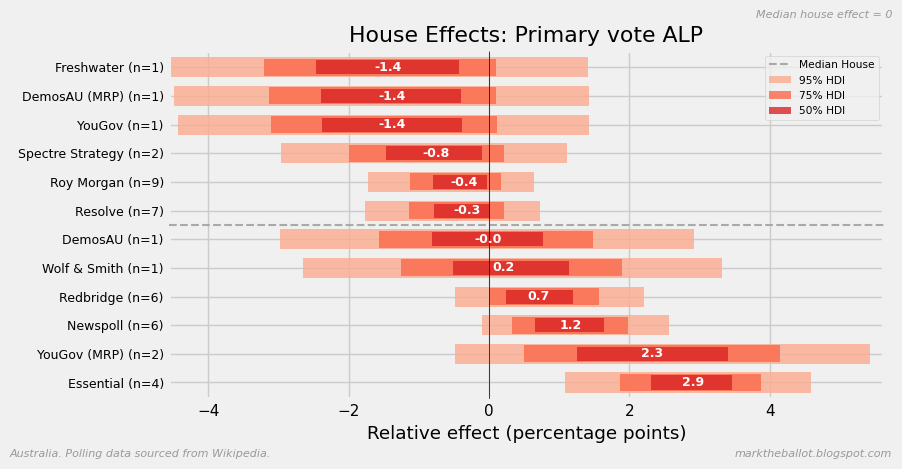

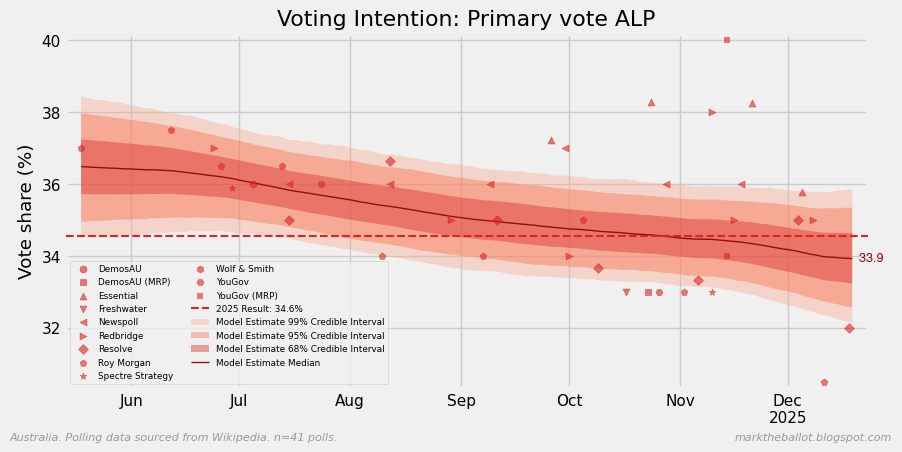


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.42
Minimum polls required: 5

Roy Morgan (n=9) ⚠️ SUSPECT
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.130 (homoskedastic)
  Recent outliers: 0@3σ, 1@2σ (of 5)
  Mean shift: -2.07 (t-test p=0.024)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.610 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.72 (t-test p=0.196)

Newspoll (n=6) ⚠️ SUSPECT
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.398 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.16 (t-test p=0.028)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.511 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.96 (t-test p=0.312)

⚠️  2 pollster(s) flagged for potential methodology issues:
   - Roy Morgan
   - Newspoll


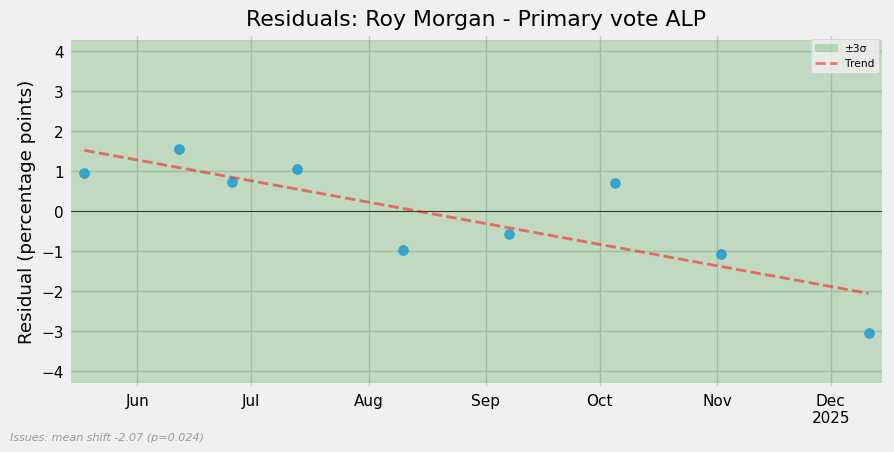

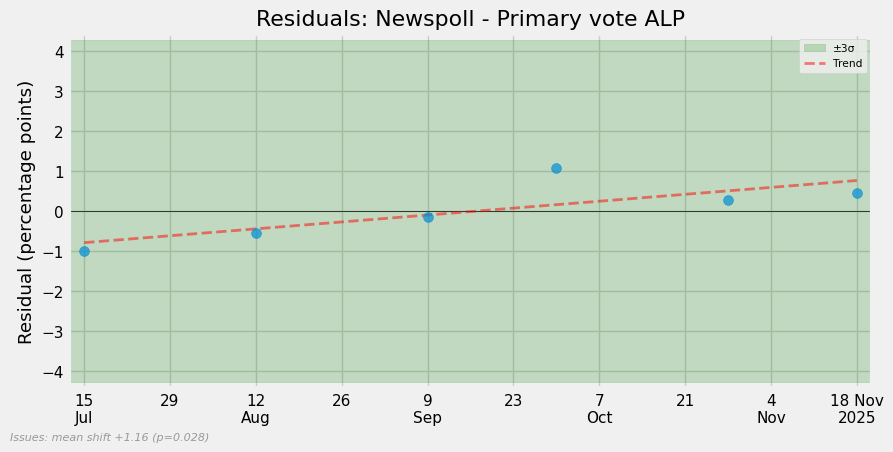


Processing: Primary vote L/NP
Polls: 41
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'YouGov (MRP)', 'Spectre Strategy', 'DemosAU (MRP)', 'YouGov', 'Freshwater', 'Wolf & Smith', 'DemosAU']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 2788
Maximum MCSE/sd ratio: 0.019
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 0.18% (comparing to observed max)
Minimum BFMI: 0.94
Completed: Primary vote L/NP


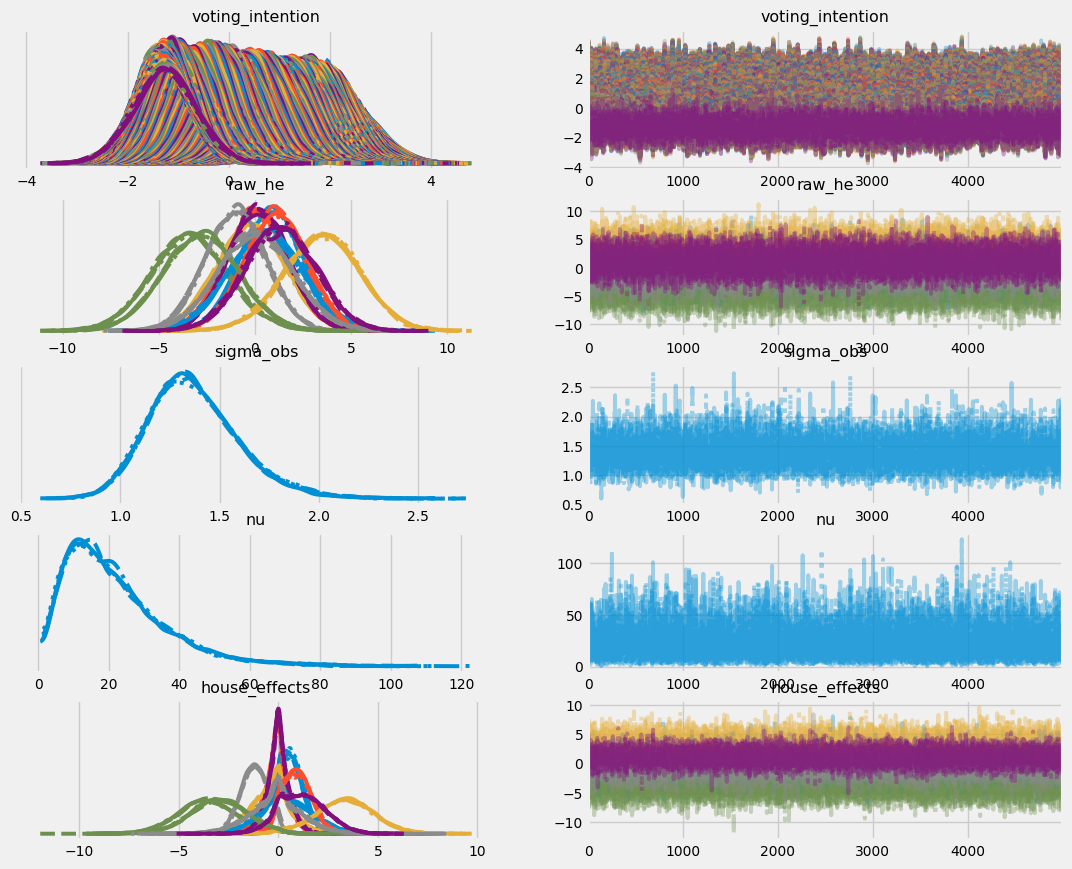

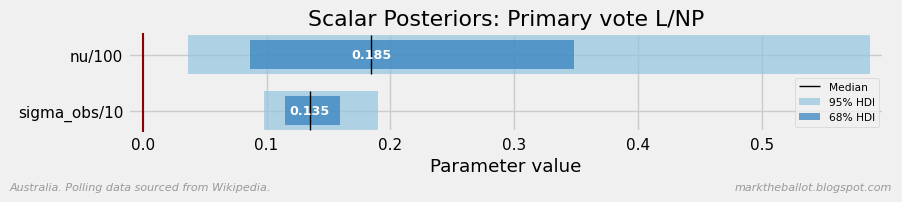

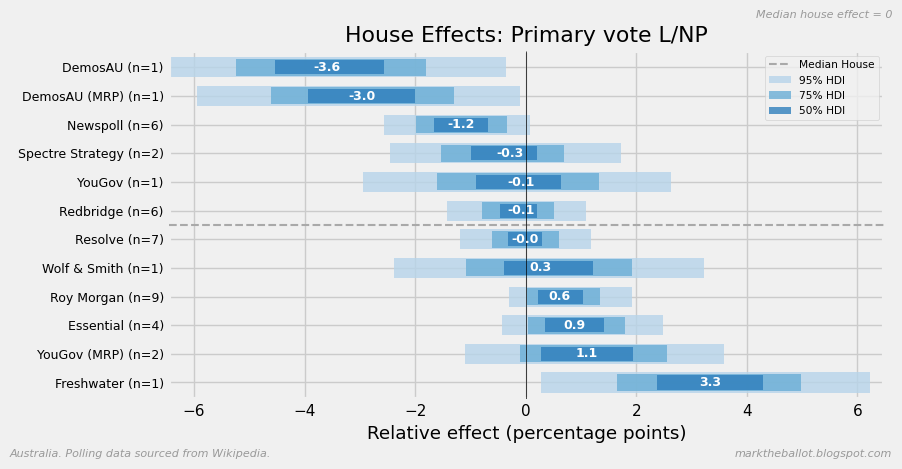

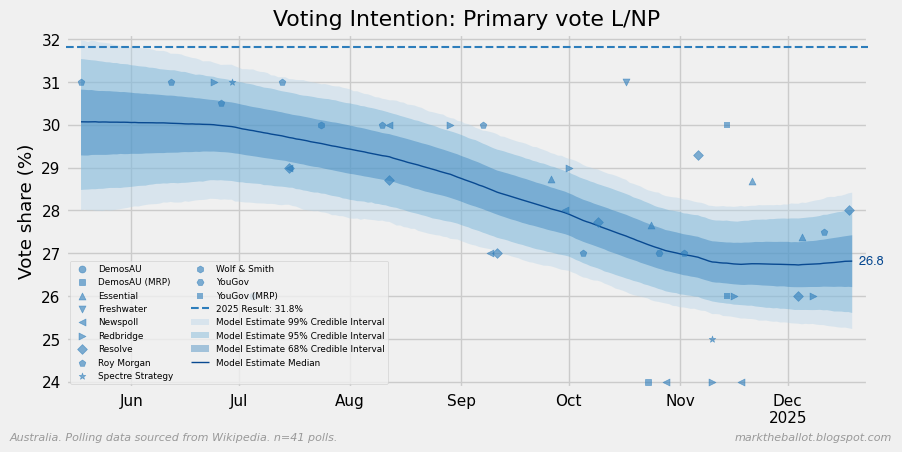


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.37
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.428 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.50 (t-test p=0.268)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.812 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -2.53 (t-test p=0.065)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.435 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -1.45 (t-test p=0.300)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.519 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.61 (t-test p=0.094)

✓ No pollsters flagged for methodology concerns.

Processing: Primary vote GRN
Polls: 40
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'YouGov (MRP)', 'Spectre Strategy', 'DemosAU (MRP)', 'YouGov', 'Freshwa

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 2889
Maximum MCSE/sd ratio: 0.020
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (12): 0.21% (comparing to observed max)
Minimum BFMI: 0.94
Completed: Primary vote GRN


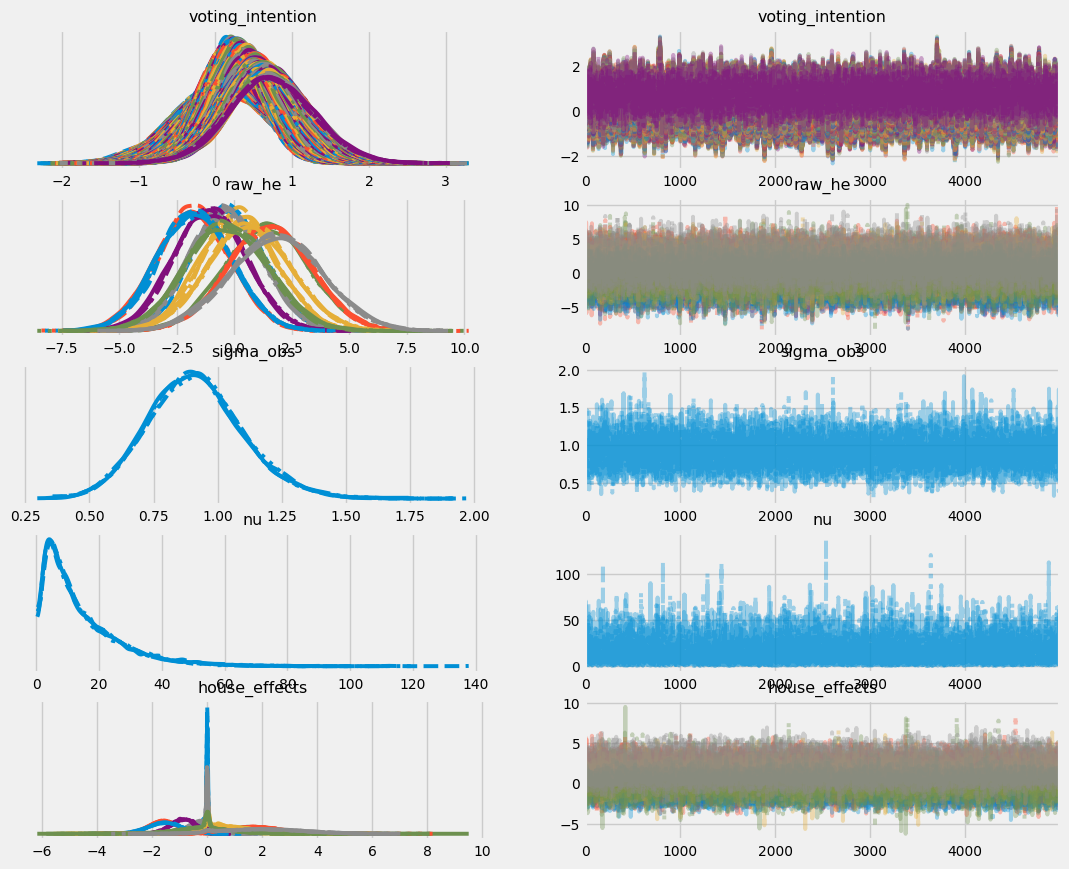

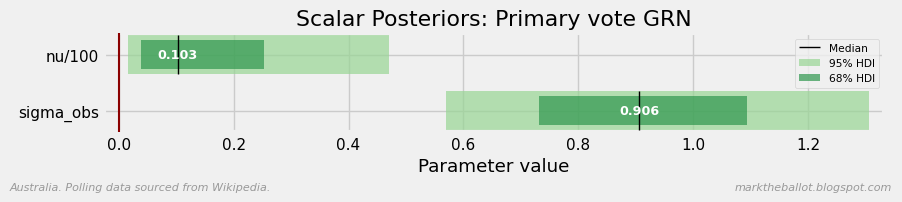

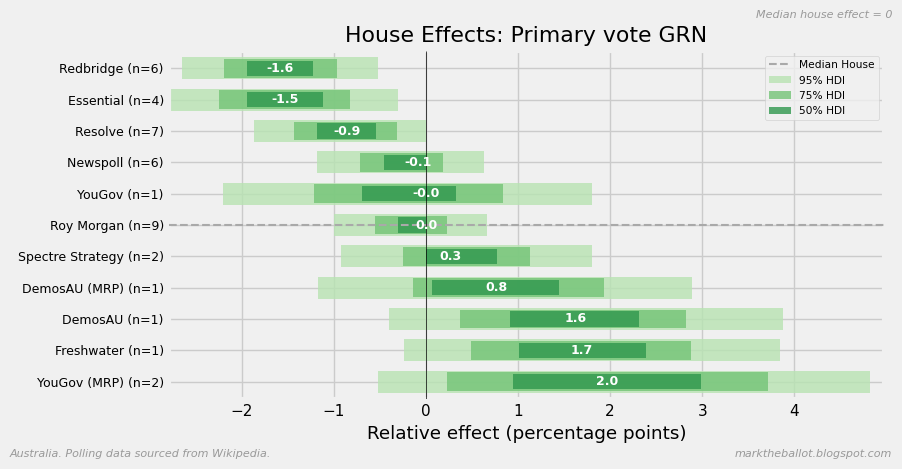

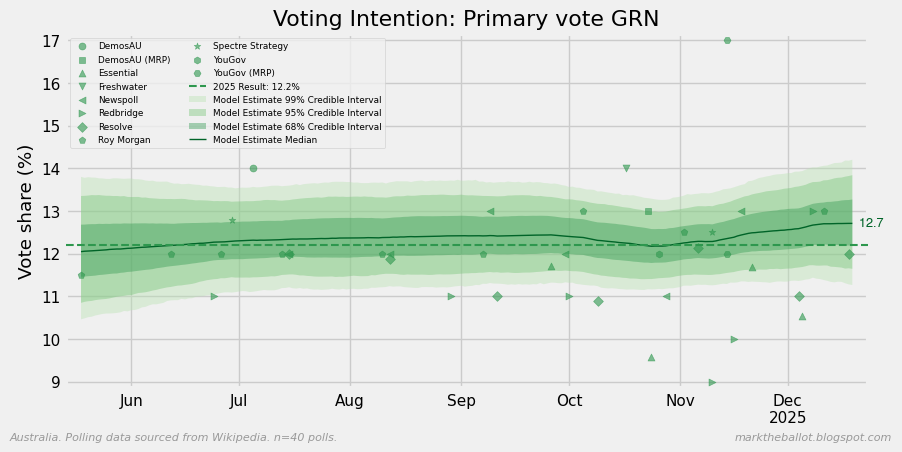


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 0.91
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.321 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +0.42 (t-test p=0.112)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.113 (homoskedastic)
  Recent outliers: 0@3σ, 1@2σ (of 5)
  Mean shift: -0.41 (t-test p=0.739)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.122 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.29 (t-test p=0.658)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.721 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.21 (t-test p=0.667)

✓ No pollsters flagged for methodology concerns.

Processing: Primary vote ONP
Polls: 40
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'YouGov (MRP)', 'Spectre Strategy', 'DemosAU (MRP)', 'YouGov', 'Freshwa

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 1440
Maximum MCSE/sd ratio: 0.027
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (11): 1.70% (comparing to observed max)
Minimum BFMI: 0.94
Completed: Primary vote ONP


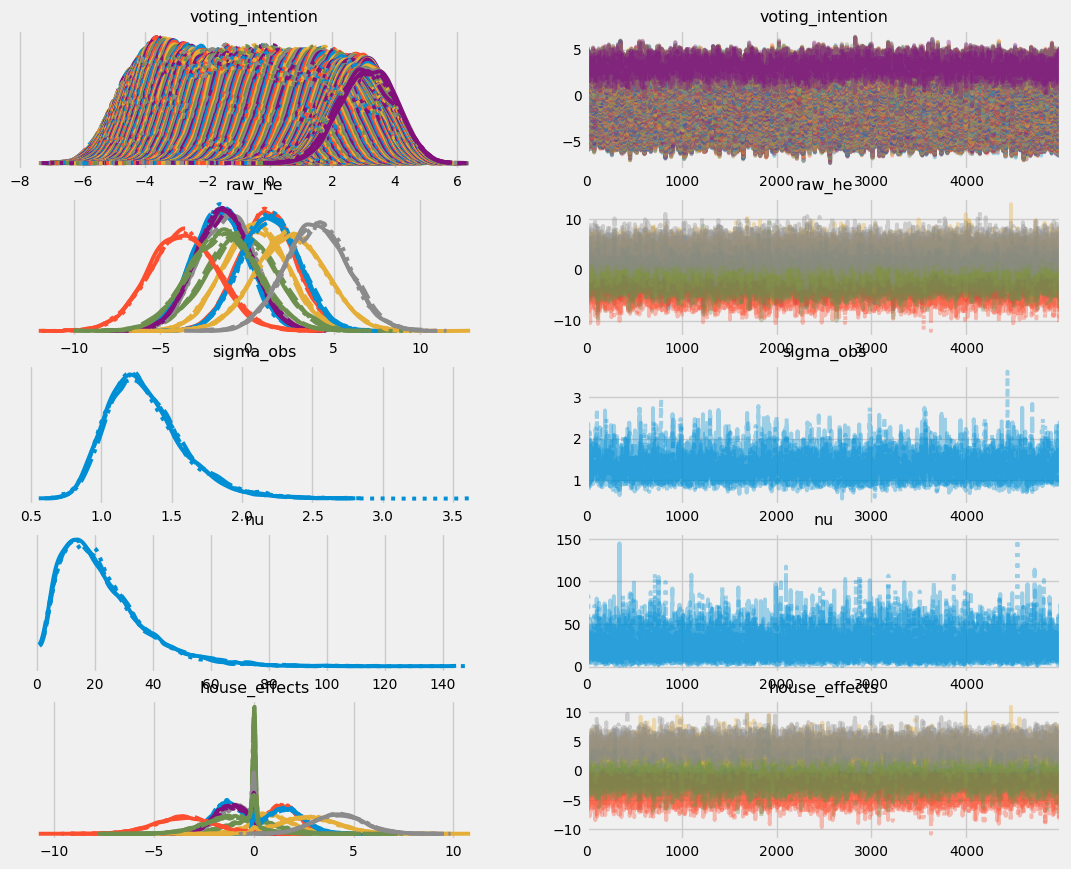

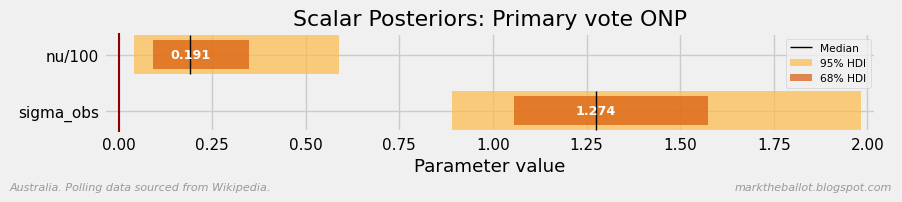

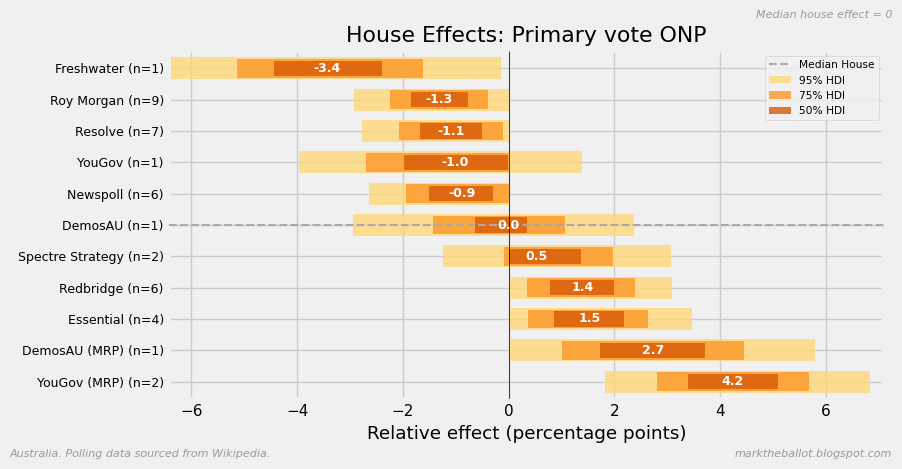

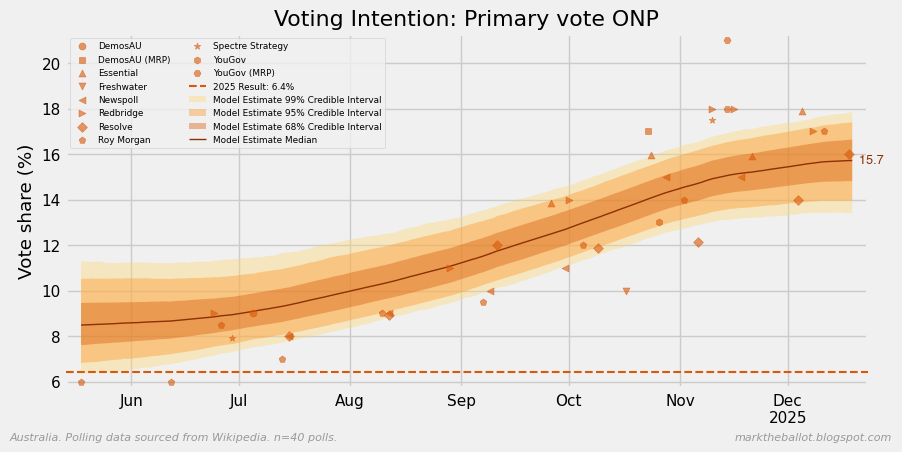


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.32
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.238 (homoskedastic)
  Recent outliers: 0@3σ, 1@2σ (of 5)
  Mean shift: +1.29 (t-test p=0.142)

Redbridge (n=6) ⚠️ SUSPECT
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.735 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +2.05 (t-test p=0.040)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.238 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +1.10 (t-test p=0.260)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.316 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.39 (t-test p=0.652)

⚠️  1 pollster(s) flagged for potential methodology issues:
   - Redbridge


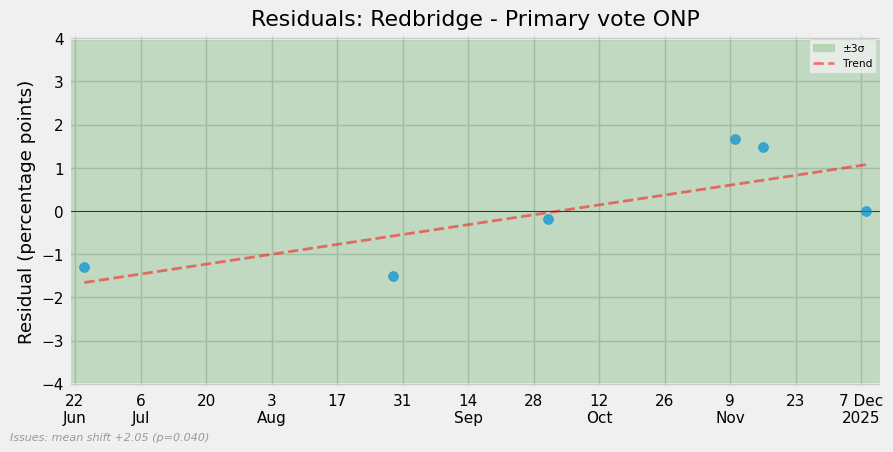


Processing: Others Primary Vote
Polls: 40
Pollsters: ['Roy Morgan', 'Resolve', 'Redbridge', 'Newspoll', 'Essential', 'YouGov (MRP)', 'Spectre Strategy', 'DemosAU (MRP)', 'YouGov', 'Freshwater', 'DemosAU']
Constraint: zero_median
sigma_obs HalfNormal prior: {'sigma': 5}
nu Gamma prior: {'alpha': 2, 'beta': 0.1}


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Maximum R-hat: 1.0000
Minimum ESS: 2332
Maximum MCSE/sd ratio: 0.021
Divergent transitions: 0/20000 (0.0000%)
Tree depth at max (12): 0.21% (comparing to observed max)
Minimum BFMI: 0.99
Completed: Others Primary Vote


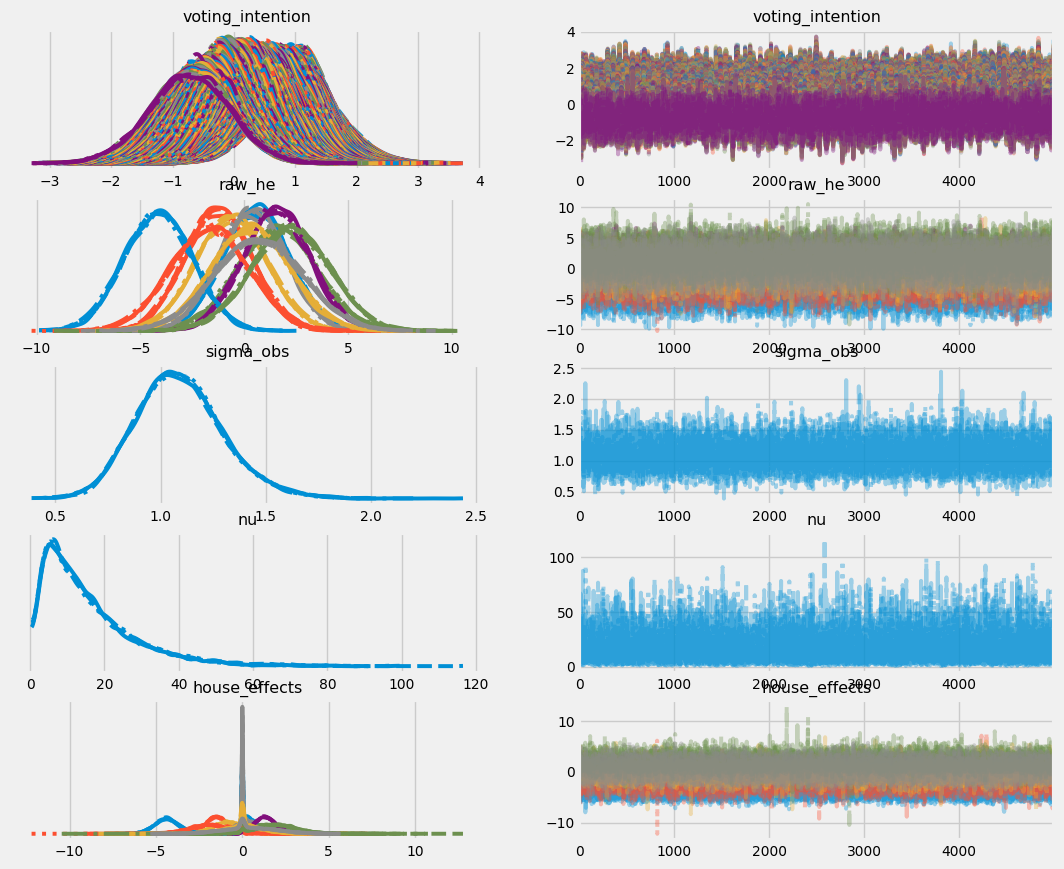

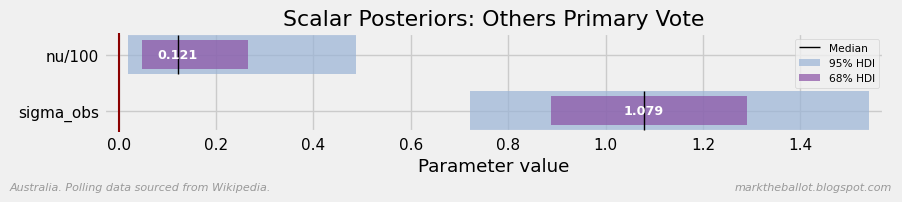

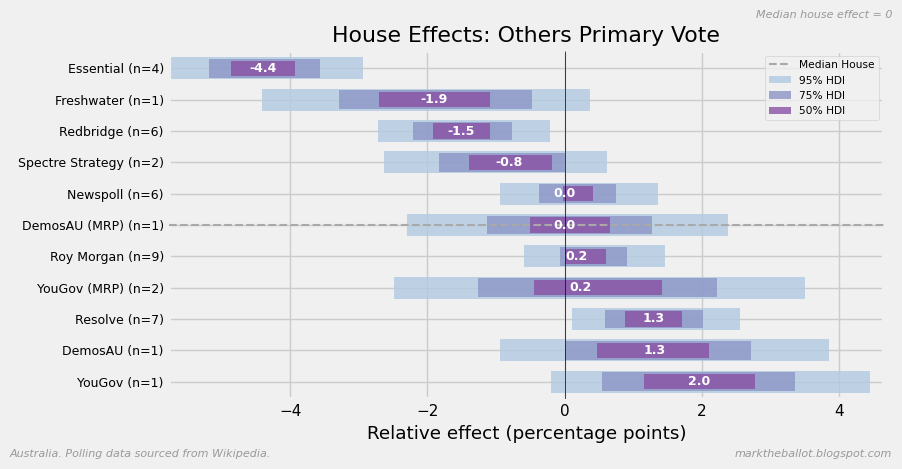

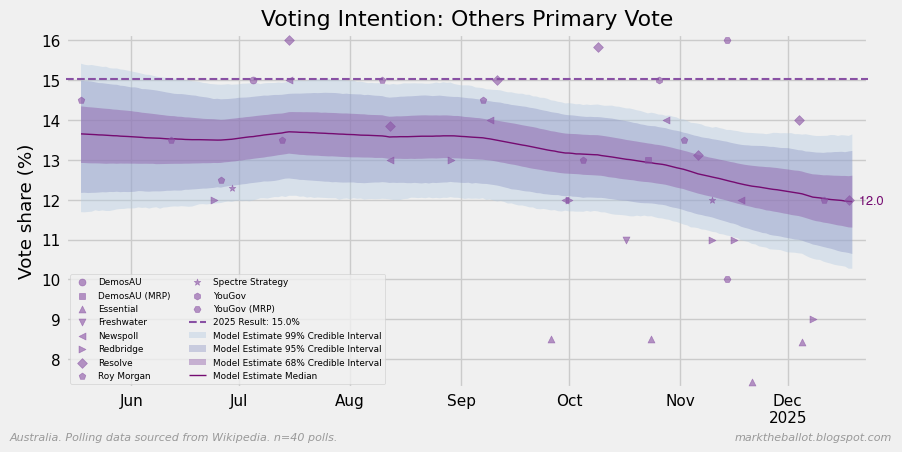


=== Residual Diagnostics by Pollster ===
Model sigma_obs: 1.09
Minimum polls required: 5

Roy Morgan (n=9)
  Outside ±3σ: 0/9 (0.0%)
  Heteroskedasticity p-value: 0.421 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: +0.66 (t-test p=0.214)

Redbridge (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.408 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.95 (t-test p=0.205)

Newspoll (n=6)
  Outside ±3σ: 0/6 (0.0%)
  Heteroskedasticity p-value: 0.658 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.56 (t-test p=0.556)

Resolve (n=7)
  Outside ±3σ: 0/7 (0.0%)
  Heteroskedasticity p-value: 0.896 (homoskedastic)
  Recent outliers: 0@3σ, 0@2σ (of 5)
  Mean shift: -0.11 (t-test p=0.903)

✓ No pollsters flagged for methodology concerns.


In [11]:
# Run model for each column
results = {}

for column in VOTE_COLUMNS:
    results[column] = run_grw_for_column(df, column)
    inputs = results[column]["inputs"]
    idata = results[column]["idata"]
    glitches = results[column]["glitches"]
    constraint = results[column]["constraint"]
    poll_counts = results[column]["poll_counts"]
    
    # Plot scalar posteriors (sigma_likelihood, nu, etc.)
    plot_posteriors_bar(
        idata,
        series_name=column,
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        palette=get_palette(column),
        show=SHOW,
    )
    
    # Plot house effects
    if constraint == "zero_median":
        rheader = "Median house effect = 0"
    else:
        he_sum_inclusions = inputs["he_sum_inclusions"]
        rheader = f"Sum to zero: {', '.join(he_sum_inclusions)}"
    plot_house_effects_bar(
        idata,
        inputs["back_firm_map"],
        model_name=column,
        poll_counts=poll_counts,
        palette=get_palette(column),
        rheader=rheader,
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        show=SHOW,
    )
    
    # Prepare poll data for plotting (needs PeriodIndex)
    df_plot = df[df[column].replace(0, np.nan).notna()].copy()
    df_plot.index = pd.PeriodIndex(df_plot[MIDDLE_DATE], freq="D")
    n_polls = len(df_plot)
    assert n_polls == sum(poll_counts.values()) 
    
    # Plot voting intention time series
    # Note: voting_intention is zero-centered; centre_offset is -mean, so subtract to restore
    vi_samples = get_vector_var("voting_intention", idata)
    vi_samples = vi_samples - inputs["centre_offset"]  # Restore original scale
    # GaussianRandomWalk creates steps+1 values, so use actual length
    date_index = pd.period_range(inputs["day_zero"], periods=len(vi_samples), freq="D")
    vi_samples.index = date_index
    
    plot_posterior_timeseries(
        data=vi_samples,
        poll_data=df_plot,
        poll_column=column,
        election_result=get_election_result(column),
        palette=get_palette(column),
        title=f"Voting Intention: {column}",
        ylabel="Vote share (%)",
        legend={"loc": "best", "fontsize": "xx-small", "ncol": 2},
        lheader=glitches if glitches else "",
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER}n={n_polls} polls.",
        show=SHOW,
    )
    
    # Check residuals for potential methodology changes
    residual_df = check_residuals(inputs, idata, verbose=True, show=SHOW)

## Finished

In [12]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

Last updated: 2025-12-30 13:03:24

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.8.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pandas    : 2.3.3
pathlib   : 1.0.1
mgplot    : 0.2.14
numpy     : 2.3.5
matplotlib: 3.10.7
arviz     : 0.22.0
sys       : 3.14.0 (main, Oct 10 2025, 12:54:13) [Clang 20.1.4 ]

Watermark: 2.5.0

